In [3]:
import spacy
import pandas as pd
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

2023-11-20 18:06:54.835123: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 18:06:55.685412: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# Importamos las librerías necesarias para el preprocesamiento
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Descargamos los paquetes necesarios para el preprocesamiento
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /home/win7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/win7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/win7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/win7/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
# Lista de stopwords
stopwords = stopwords.words("english")
# Añadimos el tag "br" a la lista de stopwords
stopwords.append("br")
# Instanciamos el lematizador
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, flag_lemmatizer=False):
    tokens = []

    for w in word_tokenize(text):
        # Convertimos a minúsculas
        w = w.lower()

        # Solo se filtran los tokens que estén compuestos por caracteres del alfabeto y que no sean stopwords
        if ((w.isalpha()) and (w not in stopwords)):
            if flag_lemmatizer:
                tokens.append(lemmatizer.lemmatize(w))
            else:
                tokens.append(w)

    return ' '.join(tokens)

In [20]:
!python3 -m spacy download es_core_news_sm

2023-11-20 18:20:35.698765: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 18:20:35.700588: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 18:20:35.723957: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 18:20:35.723990: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 18:20:35.724024: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

### Read dataset

In [7]:
df = pd.read_csv("tripadvisor_hoteles_cusco.csv")
df

,f1_hotel,f2_costo,f3_cliente,f4_titulo,f5_contenido,f6_calificacion,f7_fecHosped
0,Tocuyeros Boutique Hotel,PEN 677,julie w,Beautiful hotel,Lovely hotel in a great location. Just a short...,50,September 2023
1,Tocuyeros Boutique Hotel,PEN 677,steve w,great place and people,great place and people. we went from sept 16th...,50,September 2023
2,Tocuyeros Boutique Hotel,PEN 677,ShimonK2012,Excellent boutique hotel in prime location in ...,Our two night stay at Tocuyeros Boutique hotel...,50,September 2023
3,Tocuyeros Boutique Hotel,PEN 677,scott m,Amazing hotel!!,"Excellent accommodations, extremely friendly s...",50,August 2023
4,Tocuyeros Boutique Hotel,PEN 677,Genta M,Great time in Cusco,We had a great time in this hotel. It was clea...,50,August 2023
...,...,...,...,...,...,...,...
6095,Andean Dreams Hotel,PEN 85,pawqara,"Pricey, tiny, lame...",Pricey hotel that offers way less than what yo...,20,March 2016
6096,Andean Dreams Hotel,PEN 85,Nick P,Maybe a 1 star hotel.,"Hotel is old, smelly, toilet broken tried to f...",10,April 2015
6097,Andean Dreams Hotel,PEN 85,andresilvani,Not worth it,Yes it may be cheap but this place is disgusti...,10,April 2015
6098,Andean Dreams Hotel,PEN 85,GoLopez,Great service and location! Not bad at all...,"Stayed for 3 nights. First of all, lets be cle...",50,September 2014


In [9]:
df_filter = df[["f1_hotel", "f3_cliente", "f6_calificacion"]]
df_filter

,f1_hotel,f3_cliente,f6_calificacion
0,Tocuyeros Boutique Hotel,julie w,50
1,Tocuyeros Boutique Hotel,steve w,50
2,Tocuyeros Boutique Hotel,ShimonK2012,50
3,Tocuyeros Boutique Hotel,scott m,50
4,Tocuyeros Boutique Hotel,Genta M,50
...,...,...,...
6095,Andean Dreams Hotel,pawqara,20
6096,Andean Dreams Hotel,Nick P,10
6097,Andean Dreams Hotel,andresilvani,10
6098,Andean Dreams Hotel,GoLopez,50


In [ ]:
df_filter.describe()

,f6_calificacion
count,6100.000000
mean,39.539344
std,13.508880
min,10.000000
25%,30.000000
50%,50.000000
75%,50.000000
max,50.000000


In [ ]:
df_filter.value_counts()

f1_hotel                                   f3_cliente        f6_calificacion
Ayenda Guest House Wayra                   jd3sai            10                 2
Hotel San Juan de Dios Cusco               Rick Mayes        50                 2
Laramani Hotel Boutique                    TravelingClinton  50                 2
Cusco Magico 1 - Aparthotel Torres Kayser  Voyage762497      50                 2
Hostal El Grial                            Michael D         50                 2
                                                                               ..
Hostal Cusi Wasi                           Alyssa            50                 1
Hostal Cusco Inti                          Patricia C        50                 1
                                           Pao0321           10                 1
Hostal Cusco Internacional                 robin             10                 1
Hostal Cusi Wasi                           Sbwt              50                 1
Name: count, Length: 

<Axes: >

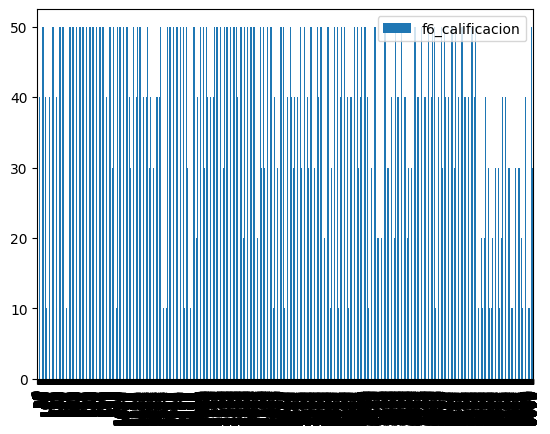

In [ ]:
df_filter.plot.bar()

In [ ]:
df_filter_edge = df_filter[df_filter["f6_calificacion"] > 25]
df_filter_edge

,f1_hotel,f3_cliente,f6_calificacion
0,Tocuyeros Boutique Hotel,julie w,50
1,Tocuyeros Boutique Hotel,steve w,50
2,Tocuyeros Boutique Hotel,ShimonK2012,50
3,Tocuyeros Boutique Hotel,scott m,50
4,Tocuyeros Boutique Hotel,Genta M,50
...,...,...,...
6077,Hostal Samani,Elaine,50
6080,Embassy Backpackers,Ramon L,40
6089,Campanario Inn Hostel,Rooni A,30
6094,Andean Dreams Hotel,Monica P,30


In [ ]:
df_filter_edge

,f1_hotel,f3_cliente,f6_calificacion
0,Tocuyeros Boutique Hotel,julie w,50
1,Tocuyeros Boutique Hotel,steve w,50
2,Tocuyeros Boutique Hotel,ShimonK2012,50
3,Tocuyeros Boutique Hotel,scott m,50
4,Tocuyeros Boutique Hotel,Genta M,50
...,...,...,...
6077,Hostal Samani,Elaine,50
6080,Embassy Backpackers,Ramon L,40
6089,Campanario Inn Hostel,Rooni A,30
6094,Andean Dreams Hotel,Monica P,30


In [ ]:
df_filter_edge["f1_hotel"].nunique()

1033

In [ ]:
df_filter_edge["f3_cliente"].nunique()

4809

In [ ]:
G = nx.from_pandas_edgelist(df_filter_edge, "f1_hotel", "f3_cliente", edge_attr=True)
G.number_of_nodes(), G.number_of_edges()

(5842, 5049)

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [33]:
nlp = spacy.load("es_core_news_sm")

In [42]:
text = "I toke a nice photos in Pisac, Choquequirao, Cusco, Ollantaytambo, Valle sagrado, and Urubamba, so I ate ceviche, papa a la huancaina" # df["f5_contenido"][0]

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)

In [44]:
text = "Hola, soy Pedro y estoy viajando por Cusco y el ceviche es delicioso. Mi amigo compró un perro negro" # df["f5_contenido"][0]

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)

In [ ]:
df["f5_contenido"][0].split(".")

['Lovely hotel in a great location',
 ' Just a short walk from the main square',
 ' Staff were very welcoming and friendly',
 ' Room was comfortable',
 ' My breakfast was amazing, I can’t eat eggs so I had a wonderful breakfast of the most delicious fruit, oatmeal and then cheese meat and avocado',
 ' I don’t particularly like avocado in the UK but over in Peru it was delicious',
 ' I was able to leave my luggage until the evening as I had a late flight',
 '']

In [ ]:
sentences = []

for k in range(len(df)):
    text_list = df["f5_contenido"][k].split(".")
    
    for text in text_list:
        temp = preprocess_text(text, flag_lemmatizer=False)
        sentences.append(temp)
sentences

['lovely hotel great location',
 'short walk main square',
 'staff welcoming friendly',
 'room comfortable',
 'breakfast amazing eat eggs wonderful breakfast delicious fruit oatmeal cheese meat avocado',
 'particularly like avocado uk peru delicious',
 'able leave luggage evening late flight',
 '',
 'great place people',
 'went sept sept',
 'weather good',
 'accommodating anything needed help requested',
 'breakfast delicious fresh bread fruit meats coffee lots tea options like cheap breakfasts us',
 'able upgrade room good price',
 'know cusco plumbing heating different us',
 'want putting toilet paper toilet',
 'let us early late checkout',
 'construction early morning',
 'oh mr',
 'steve thank much amazing comment think us tripadvisor community appreciate recommendation',
 'glad met us',
 'wish come back soon keep enjoying cusco tocuyeros',
 'tocuyeros team',
 'two night stay tocuyeros boutique hotel staff excellent',
 'bedroom including bathroom generous size comfortable clean',
 '

In [ ]:
text = "The young man, still a boy, is played by Jake Gyllenhaal, one of his first staring assignments, I think."
doc = nlp(text)

In [ ]:
data = []
columns = ["text", "lemma", "pos", "tag", "dep", "shape", "is_alpha", "is_stop"]
for token in doc:
    data.append([token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop])

df_doc = pd.DataFrame(data, columns=columns)
df_doc

,text,lemma,pos,tag,dep,shape,is_alpha,is_stop
0,Lovely,lovely,ADJ,JJ,amod,Xxxxx,True,False
1,hotel,hotel,NOUN,NN,ROOT,xxxx,True,False
2,in,in,ADP,IN,prep,xx,True,True
3,a,a,DET,DT,det,x,True,True
4,great,great,ADJ,JJ,amod,xxxx,True,False
...,...,...,...,...,...,...,...,...
86,had,have,VERB,VBD,advcl,xxx,True,True
87,a,a,DET,DT,det,x,True,True
88,late,late,ADJ,JJ,amod,xxxx,True,False
89,flight,flight,NOUN,NN,dobj,xxxx,True,False


In [ ]:
def get_entities(sent):
      ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

In [ ]:
text_list = df["f5_contenido"][0].split(".")
print(text_list)

text = text_list[0]
# text = "the film had 200 patents"

print(text)
get_entities(text)

['Lovely hotel in a great location', ' Just a short walk from the main square', ' Staff were very welcoming and friendly', ' Room was comfortable', ' My breakfast was amazing, I can’t eat eggs so I had a wonderful breakfast of the most delicious fruit, oatmeal and then cheese meat and avocado', ' I don’t particularly like avocado in the UK but over in Peru it was delicious', ' I was able to leave my luggage until the evening as I had a late flight', '']
Lovely hotel in a great location


['', 'great  location']

In [ ]:
entity_pairs = []

for k in range(len(df)):
    text_list = df["f5_contenido"][k].split(".")
    for text in text_list:
        entities = get_entities(text)
        entity_pairs.append(entities)

In [ ]:
def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [
        {'DEP':'ROOT'}, 
        {'DEP':'prep','OP':"?"},
        {'DEP':'agent','OP':"?"},  
        {'POS':'ADJ','OP':"?"}
    ]

    matcher.add("matching_1", [pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [ ]:
get_relation("John completed the task")

'completed'

In [ ]:
entity_pairs = []
relations = []
data = []
for k in range(len(df)):
    text_list = df["f5_contenido"][k].split(".")
    for text in text_list:
        entities = get_entities(text)
        
        try:
            relation = get_relation(text)
            relations.append(relation)
            entity_pairs.append(entities)
        except:
            pass

In [ ]:
entity_pairs = []
relations = []
data = []
for text in sentences:
    entities = get_entities(text)
    
    try:
        relation = get_relation(text)
        relations.append(relation)
        entity_pairs.append(entities)
    except:
        pass

In [ ]:
pd.Series(relations).value_counts()[:50]

stayed         1041
recommend       881
stay            864
hotel           290
clean           286
get             282
staff           270
made            258
cusco           248
room            240
included        237
helpful         231
went            222
breakfast       216
enjoyed         216
location        207
help            202
go              202
regards         195
arrived         194
helped          193
walk            188
come            186
rooms           184
place           184
told            182
got             173
want            171
see             171
came            168
said            162
make            160
need            159
found           154
took            150
friendly        146
take            146
thank much      143
let             140
recommended     135
shower          132
good            130
thank           130
find            127
asked           125
hostel          124
say             122
provided        122
gave            122
think           117


In [ ]:
entity_pairs

[['', ''],
 ['', ''],
 ['staff', ''],
 ['', ''],
 ['', ''],
 ['', 'particularly uk peru delicious'],
 ['', 'luggage evening'],
 ['', ''],
 ['', ''],
 ['', ''],
 ['accommodating', 'needed  help'],
 ['fresh bread fruit meats', 'cheap lots tea breakfasts'],
 ['', ''],
 ['cusco plumbing', 'different  us'],
 ['', 'toilet toilet'],
 ['us', ''],
 ['', ''],
 ['', ''],
 ['amazing us tripadvisor community', 'recommendation'],
 ['', 'glad  us'],
 ['wish', 'soon cusco tocuyeros'],
 ['', ''],
 ['two  night', 'boutique hotel staff'],
 ['', 'comfortable  clean'],
 ['good prepared order dining room', 'meal'],
 ['', ''],
 ['', 'pleased  home'],
 ['comments  us', 'right  track'],
 ['kind comment hope', 'soon tocuyeros team'],
 ['', ''],
 ['', 'great  ambiance'],
 ['', ''],
 ['', 'visitors'],
 ['', ''],
 ['', 'glad  us'],
 ['goal', 'wonderful  time'],
 ['hope', 'back  visit'],
 ['best', 'tocuyeros team'],
 ['', ''],
 ['', ''],
 ['', 'late  checkout'],
 ['', 'highly  place'],
 ['dear  thank', 'much  revie

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]
print(len(source), len(target), len(relations))
df_kg = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
df_kg

42635 42635 42635


,source,target,edge
0,,,location
1,,,square
2,staff,,welcoming friendly
3,,,comfortable
4,,,eggs wonderful
...,...,...,...
42630,,,breakfast sad
42631,,,carpets
42632,tv,weird noise,made weird
42633,,nice people,switched nice


In [ ]:
import numpy as np
df_kg.replace("", np.nan, inplace=True)
df_kg.dropna(inplace=True)
df_kg

,source,target,edge
10,accommodating,needed help,requested
11,fresh bread fruit meats,cheap lots tea breakfasts,options like cheap
13,cusco plumbing,different us,know
18,amazing us tripadvisor community,recommendation,thank much
20,wish,soon cusco tocuyeros,keep
...,...,...,...
42614,safe everything,honest plaza hostel,come
42623,sliced cheese hotdog,hot chocolate milk,included
42624,satisified go jack cafe,american block breakfasts,find big
42625,staff,local activities,suggested many


In [ ]:
df_kg[:100]

,source,target,edge
10,accommodating,needed help,requested
11,fresh bread fruit meats,cheap lots tea breakfasts,options like cheap
13,cusco plumbing,different us,know
18,amazing us tripadvisor community,recommendation,thank much
20,wish,soon cusco tocuyeros,keep
...,...,...,...
283,peruvian prints,art,cool
288,loved room décor,open area,went
289,loud noises,doors,made worse
290,enough cleaners,doors,knocked


/home/win7/miniconda3/envs/min_web/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/win7/miniconda3/envs/min_web/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47476 (\N{HANGUL SYLLABLE REU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/win7/miniconda3/envs/min_web/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/win7/miniconda3/envs/min_web/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/win7/miniconda3/envs/min_web/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44305 (\N{HANGUL SYLLABL

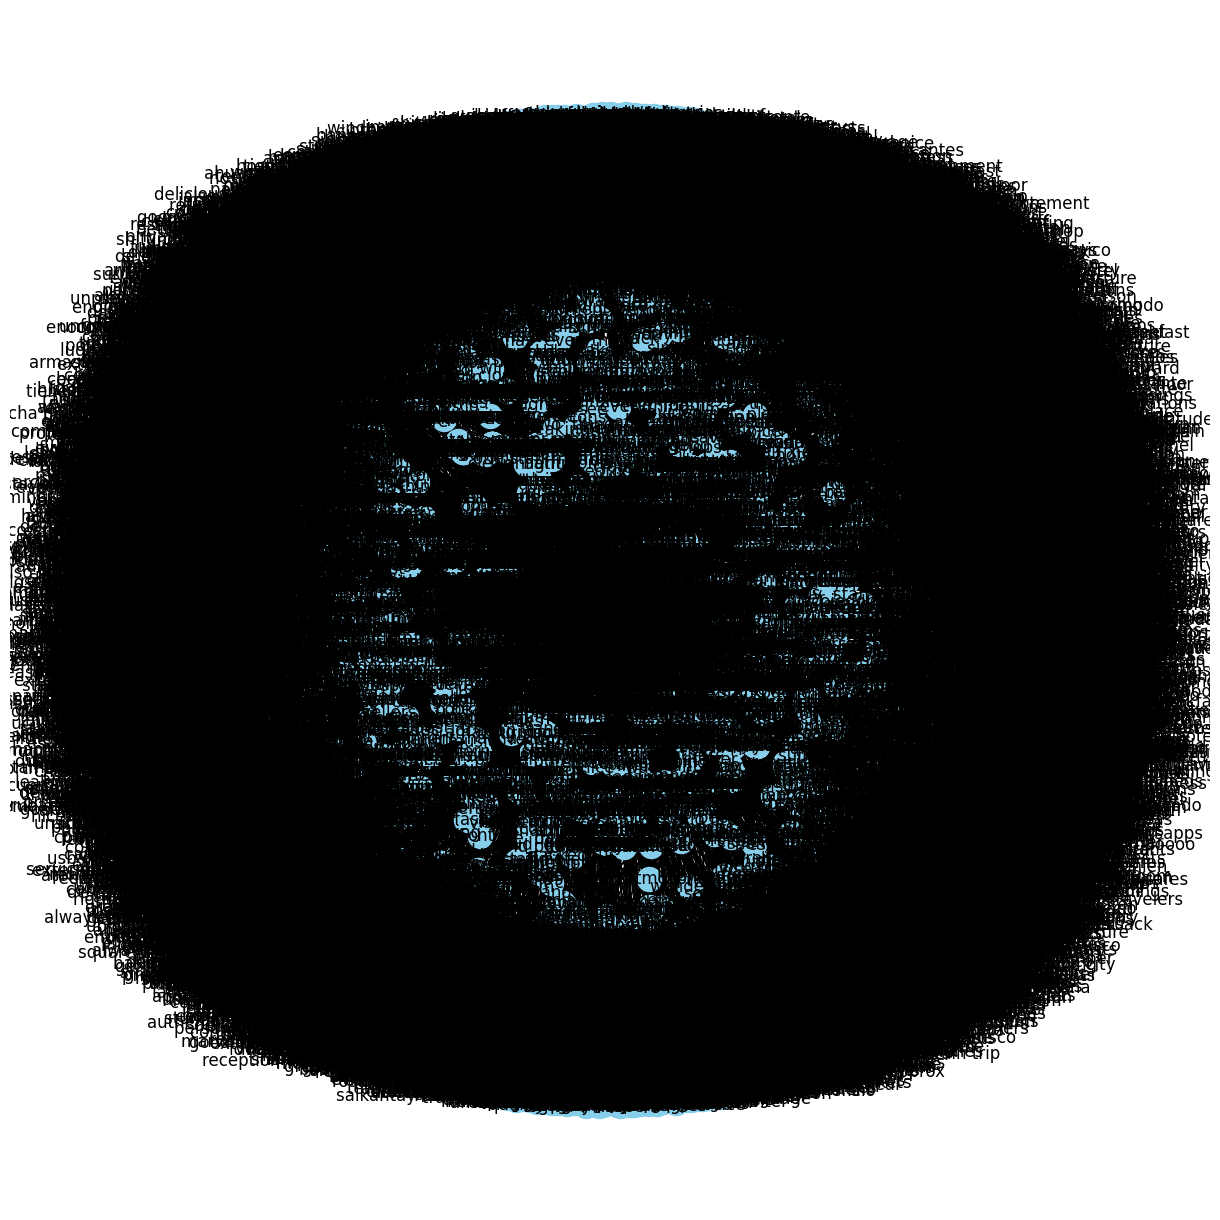

In [ ]:
G=nx.from_pandas_edgelist(df_kg, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
G.number_of_nodes(), G.number_of_edges()

(22152, 15847)

In [ ]:
text = df["f5_contenido"][0]

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)

NameError: name 'df' is not defined

In [1]:
import spacy
from spacy.matcher import Matcher

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# Create a Matcher object
matcher = Matcher(nlp.vocab)

# Define a pattern for matching: Here, we are looking for the phrase "example of"
pattern = [{"LOWER": "example"}, {"LOWER": "of"}]

# Add the pattern to the matcher with a unique name and the defined pattern
matcher.add("example_pattern", [pattern])

# Text to be processed
text = "This is an easy example of SpaCy Matcher in action."

# Process the text with SpaCy
doc = nlp(text)

# Use the matcher on the processed text
matches = matcher(doc)

# Iterate over the matches and print the matched span
for match_id, start, end in matches:
    matched_span = doc[start:end]
    print(f"Match found: '{matched_span.text}' (start: {start}, end: {end})")


2023-11-21 13:29:45.809464: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-21 13:29:45.811587: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-21 13:29:45.843215: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 13:29:45.843246: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 13:29:45.843260: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Match found: 'example of' (start: 4, end: 6)


In [4]:
def on_match(matcher, doc, id, matches):
    print('Matched!', matches)

matcher = Matcher(nlp.vocab)
patterns = [
    [{"LOWER": "hello"}, {"LOWER": "world"}],
    [{"ORTH": "Google"}, {"ORTH": "Maps"}]
]
matcher.add("TEST_PATTERNS", patterns, on_match=on_match)
doc = nlp("HELLO WORLD on Google Maps.")
matches = matcher(doc)

Matched! [(3004906285683798724, 0, 2), (3004906285683798724, 3, 5)]
Matched! [(3004906285683798724, 0, 2), (3004906285683798724, 3, 5)]
